In [27]:
import requests
import json
import cv2
import util
from config_reader import config_reader
import numpy as np
import pandas as pd
from StringIO import StringIO

In [10]:
addr = 'http://localhost:8080'
test_url = addr + '/invocations'

In [11]:
content_type = 'image/jpeg'
headers = {'content-type': content_type}

In [12]:
oriImg = cv2.imread('test.jpeg')

In [13]:
param, model_params = config_reader()
scale = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']][3]                      
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))

imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        

In [14]:
_, img_encoded = cv2.imencode('.jpg', imageToTest_padded)

In [15]:
# %%timeit
# response = requests.post(test_url, data=img_encoded.tostring(), headers=headers)

In [17]:
response = requests.post(test_url, data=img_encoded.tostring())
print (response)

<Response [200]>


In [21]:
result = response.text

In [37]:
df = pd.read_csv(StringIO(result),header=None)

In [42]:
heatmap = df[0].values.reshape(92, 69, 19)

In [43]:
heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


In [44]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

COCO Output Format
Nose – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
LAnkle – 13, Right Eye – 14, Left Eye – 15, Right Ear – 16,
Left Ear – 17, Background – 18

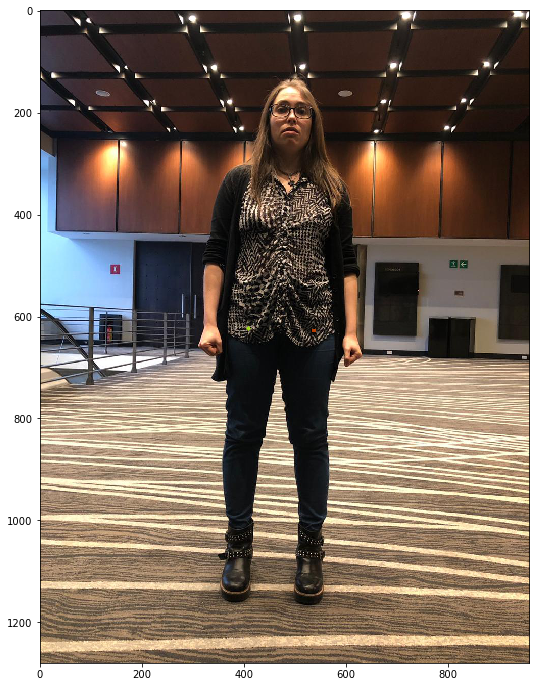

In [58]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
test_image = 'test.jpeg'

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in [8,11]:
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [61]:
# Right shoulder, elbow, wrist
(all_peaks[2],all_peaks[3],all_peaks[4])

([(393, 332, 0.6995969137802427, 2)],
 [(344, 479, 0.6736550652806786, 3)],
 [(333, 616, 0.8392920991208861, 4)])

In [62]:
# Left shoulder, elbow, wrist
(all_peaks[5],all_peaks[6],all_peaks[7])

([(574, 355, 0.6543340881345239, 5)],
 [(601, 503, 0.7049430325778644, 6)],
 [(610, 631, 0.8371880641133793, 7)])

In [55]:
all_peaks[8]

[(408, 624, 0.41582663324510166, 8)]

In [59]:
all_peaks[11]

[(536, 628, 0.39280825571809386, 11)]